# Concurrencia en Python

In [ ]:
%load_ext autoreload
%autoreload 2

Cualquier duda:

Mail: axel.sirota@gmail.com

Twitter: @AxelSirota

# Modos de concurrencia en Python

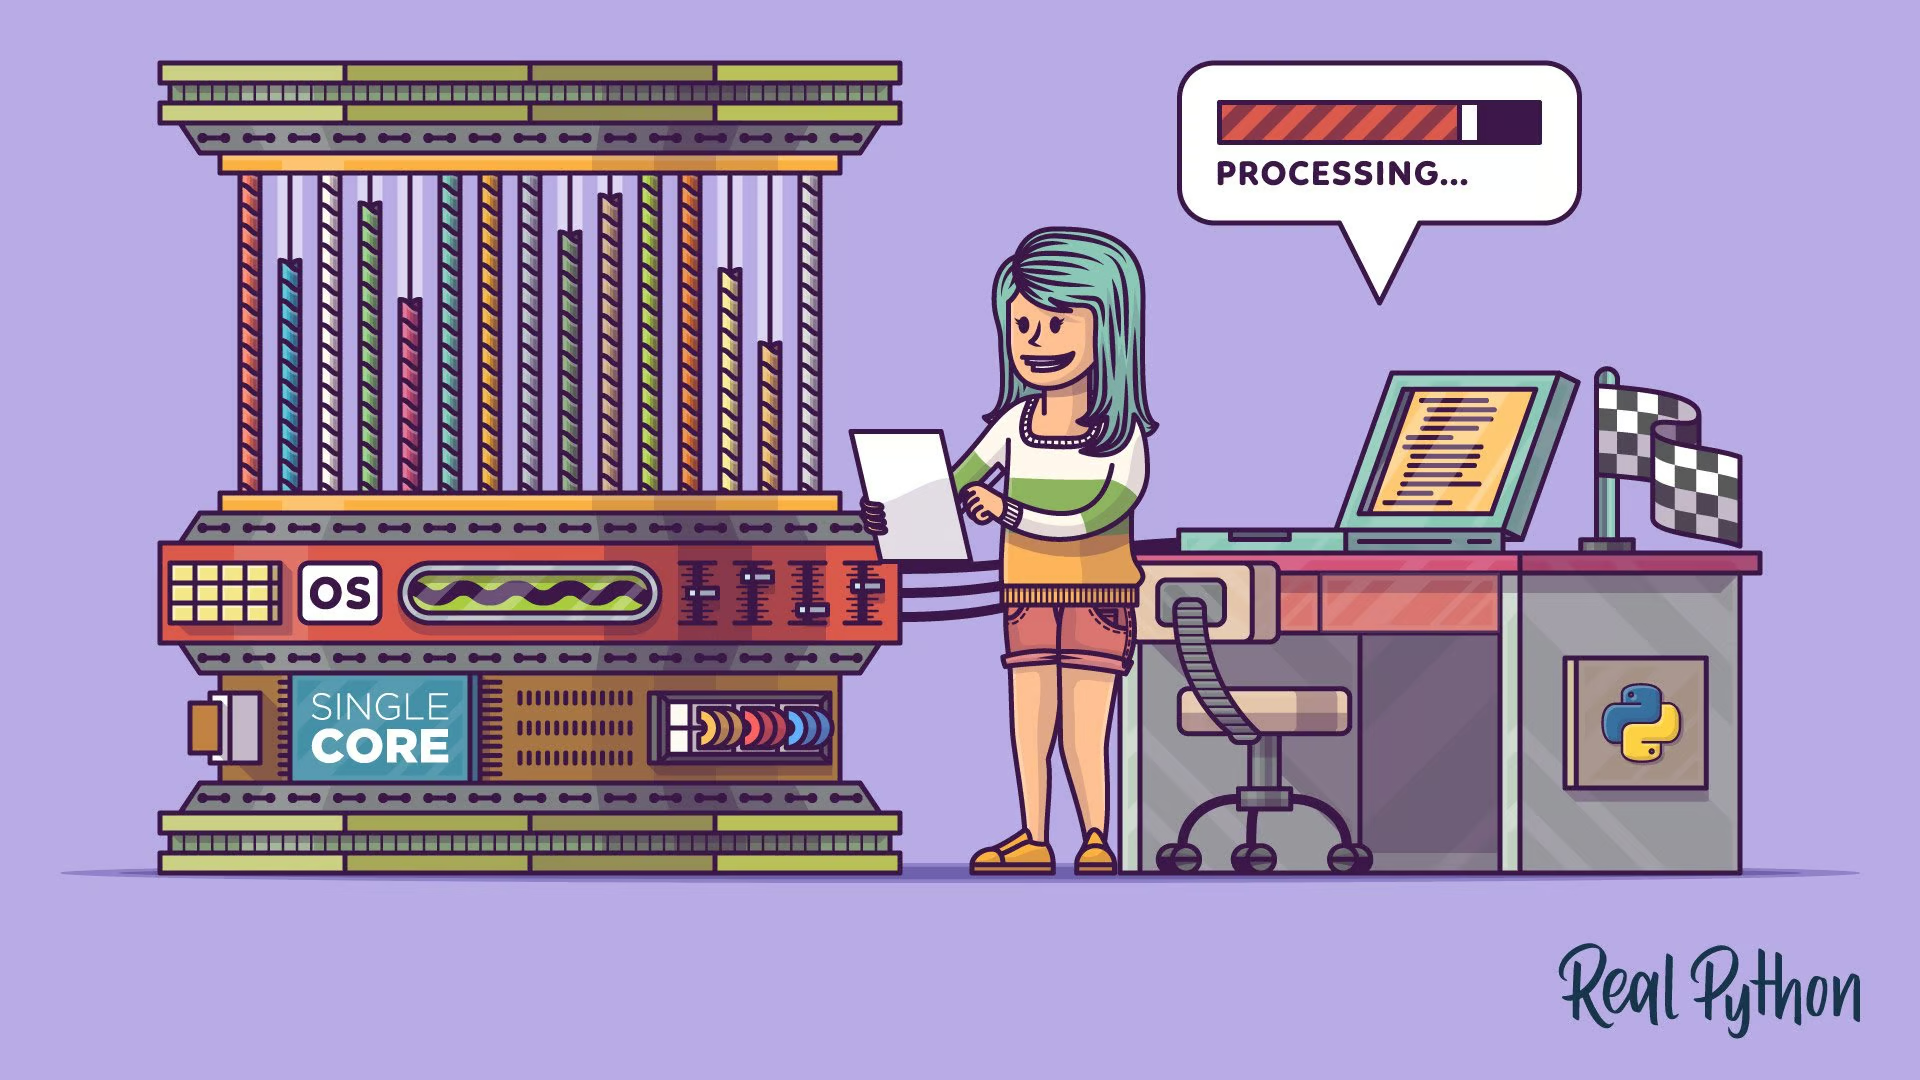

En Python tenemos tres modos de concurrencia y paralelismo:

- Threading
- Multiprocessing
- Asyncio

## Threading

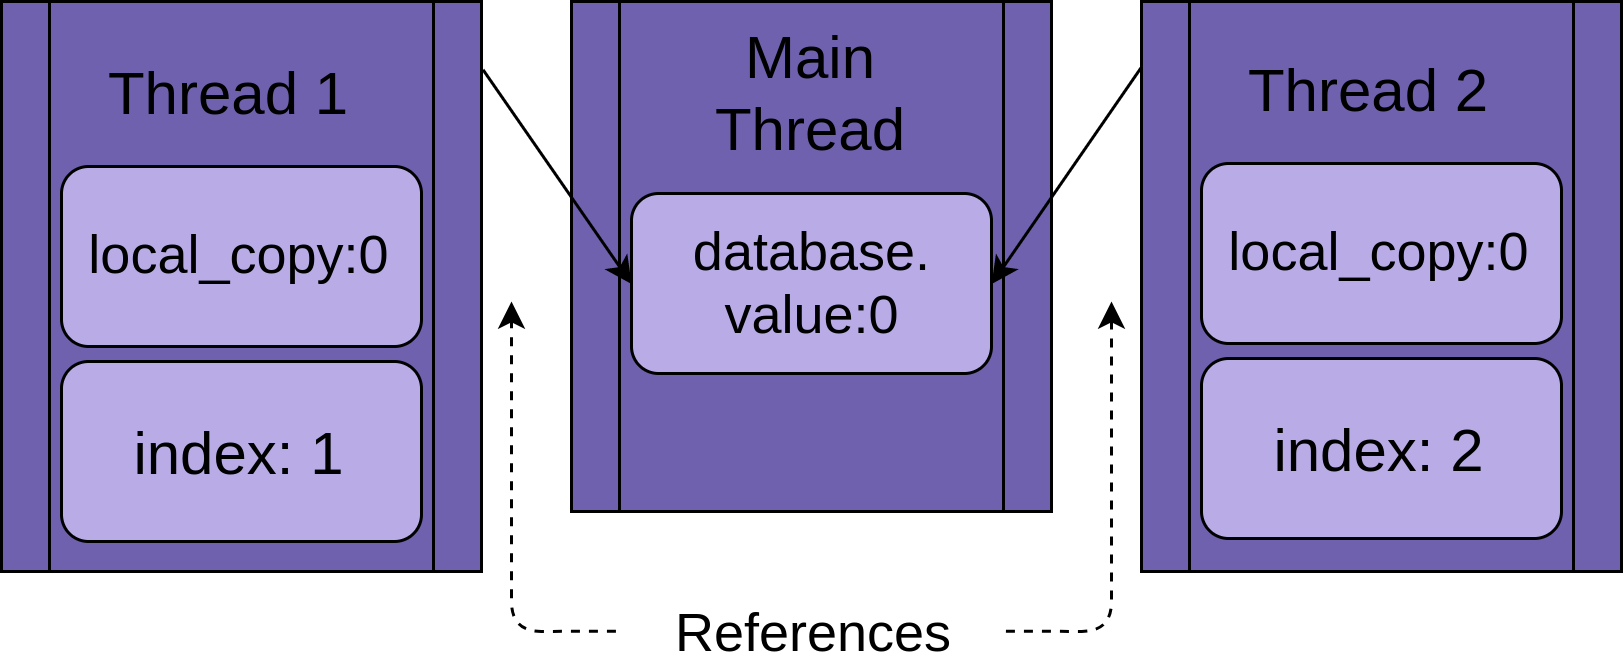

**Tipo de Concurrencia: Concurrencia Preemtiva**

Claves:

- Main stack compartido
- Impacto medio en memoria por referencias locales de variable read/write
- Esto puede causar race conditions
- Cada vez que hay una I/O operation hay un switch en el procesador. Tambien si el Thread toma mas que "N tick times"

In [ ]:
from threading import Thread

class InputReader(Thread):
    """Ejemplo de Thread, extiende Thread class"""

    def run(self):
        """
        Lo que vaya a ejecutar el Thread
        """
        self.line_of_text = input('Texto Random: ')

input('Si capitan, estamos listos? ')
thread = InputReader() # create thread object
thread.start() # cf. thread.run() for no concurrency

count, result = 1, 1

while thread.is_alive():
    result = count * count
    count += 1

print(f'Calcule cuadrados {count:,} * {count:,} = {result:,}')
print(f'mientras tipeaste "{thread.line_of_text}"')

Si capitan, estamos listos? si
Texto Random: hola
Calcule cuadrados 2,676,778 * 2,676,778 = 7,165,135,107,729
mientras tipeaste "hola"


Puntos clave:

- La funcion input abre un socket y se quede esperando, esa operacion I/O hace que el flujo de ejecucion vaya al Main Thread



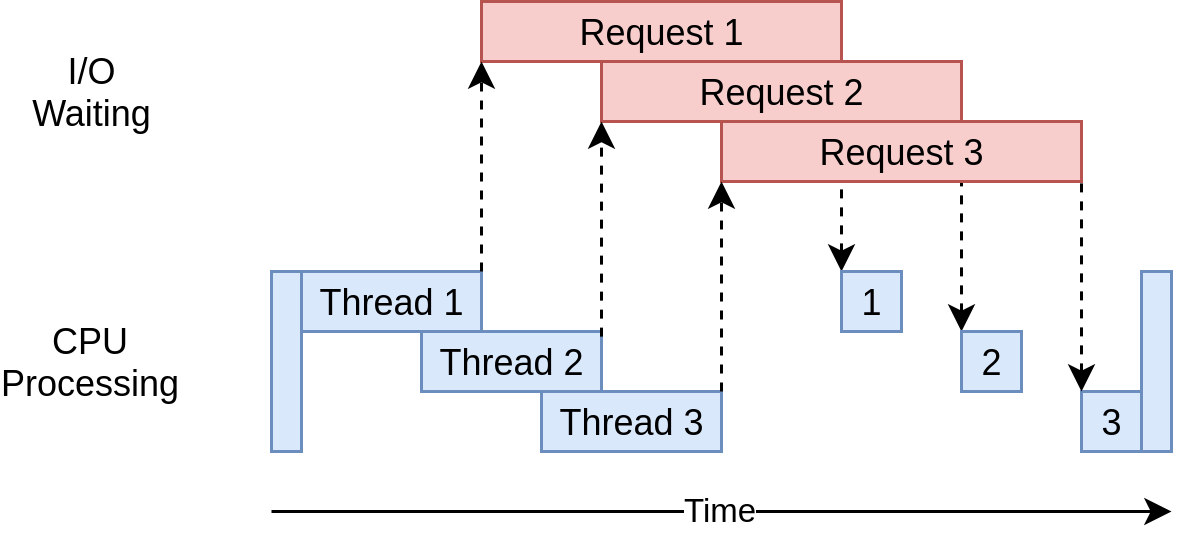

- Notemos el patron:



```
while sentinel:
   # do stuff
```

Asi es como vamos comunicarnos con el Thread, sentinel puede ser un Evento, tal que el thread mire y se muera; o puede ser una senal del Thread a nosotros para joinearlo.

### Navegando entre race conditions

In [1]:
import threading

counter = 0

def worker():
    'My job is to increment the counter and print the current count'
    global counter

    counter += 1
    print('The count is %d' % counter)
    print('---------------')

print('Starting up')
for i in range(10):
    threading.Thread(target=worker).start()  # Lo mismo que crear un Thread class y poner worker como el codigo de run()
print('Finishing up')


Starting up
The count is 1
---------------
The count is 2
---------------
The count is 3
---------------
The count is 4
---------------
The count is 5
---------------
The count is 6
---------------
The count is 7
---------------
The count is 8
---------------
The count is 9
---------------
The count is 10
---------------
Finishing up


La pregunta es: **Funciona??**

- La cuenta parece bien
- El print esta raro

**Que paso?**

Siempre nos enseñaron que alteral una variable read/write como counter sin sincronizacion entre los threads genera una race condition, en este caso en counter. **Porque no la vemos?**

Porque el procesador es muy rapido, vamos a hacerlo tonto con una tecnica llamada **fuzzing**.

In [ ]:
import threading, time, random

##########################################################################################
# Fuzzing is a technique for amplifying race condition errors to make them more visible

FUZZ = True

def fuzz():
    if FUZZ:
        time.sleep(random.random())

###########################################################################################

counter = 0

def worker():
    'My job is to increment the counter and print the current count'
    global counter

    fuzz()
    oldcnt = counter
    fuzz()
    counter = oldcnt + 1
    fuzz()
    print('The count is %d' % counter, end='')
    fuzz()
    print()
    fuzz()
    print('---------------', end='')
    fuzz()
    print()
    fuzz()

print('Starting up')
fuzz()
for i in range(10):
    threading.Thread(target=worker).start()
    fuzz()
print('Finishing up')
fuzz()

Starting up
The count is 1
---------------
The count is 2The count is 2
The count is 3---------------
The count is 3The count is 3

The count is 4
---------------

------------------------------

------------------------------Finishing up
The count is 4

Mucho mejor, no? Aca tenemos **dos** race conditions, cuales? Como las arreglamos?

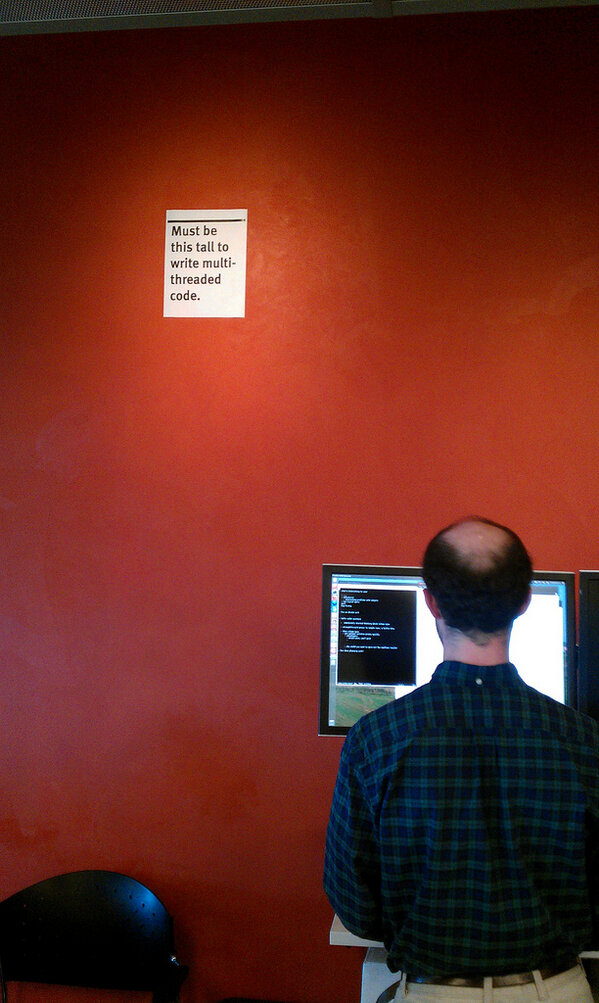

### Queues, not Locks

La solucion es usar Atomic Message Queues con un Manager para cada race condition. Resolvamos el race condition del counter primero, y queda de tarea el otro.

In [ ]:
import threading, time, random, queue

counter = 0

counter_queue = queue.Queue()
sentinel = threading.Event()

def counter_manager():
    'I have EXCLUSIVE rights to update the counter variable'
    global counter
    while True:
        increment = counter_queue.get()
        fuzz()
        oldcnt = counter
        fuzz()
        counter = oldcnt + increment
        fuzz()
        print(f'\nThe count is {counter}\n---------------\n')
        fuzz()
        counter_queue.task_done()


t = threading.Thread(target=counter_manager)
t.start()

def worker():
    'My job is to increment the counter and print the current count'
    counter_queue.put(1)
    fuzz()

print('Starting up')
fuzz()

worker_threads = []
for i in range(10):
    t = threading.Thread(target=worker)
    worker_threads.append(t)
    t.start()
    fuzz()

sentinel.set()

for worker in worker_threads:
    fuzz()
    worker.join()

counter_queue.join()
fuzz()
print('Finishing up')
fuzz()

Starting up

The count is 1
---------------


The count is 2
---------------


The count is 3
---------------


The count is 4
---------------


The count is 5
---------------


The count is 6
---------------


The count is 7
---------------


The count is 8
---------------


The count is 9
---------------


The count is 10
---------------

Finishing up


## Multiprocessing

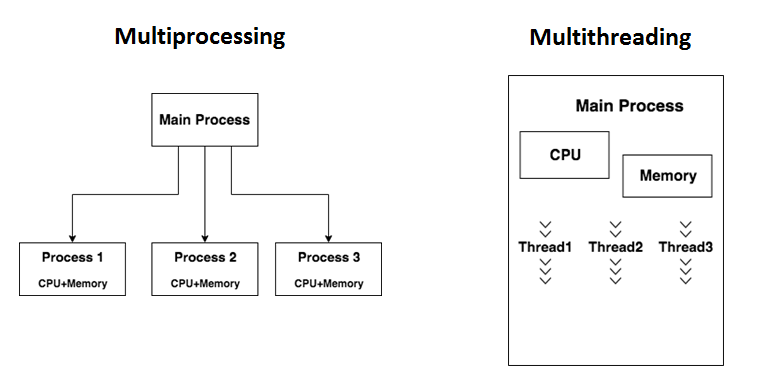

**Tipo de *Concurrencia*: Paralelismo**

Claves:

- Main stack **no** compartido
- Impacto alto en memoria por duplicacion del stack
- No genera race conditions
- Cada Proceso avanza independientemente. Para sincronizar necesitamos Pipes

In [ ]:
%%writefile muchcpuwithtime.py

from multiprocessing import Process
import os
import time


class MuchCPU(Process):
    def run(self):
        t = time.time()
        print(os.getpid()) # get process ID
        for i in range(80_000_000):
            result = i * i
        print(f'{os.getpid()} took {time.time()-t} seconds')

Overwriting muchcpuwithtime.py


In [ ]:
from multiprocessing import Process, cpu_count
import time
from muchcpuwithtime import MuchCPU


if __name__ == '__main__':
    print('Running...')
    procs = [MuchCPU() for f in range(cpu_count())]
    t = time.time()

    for p in procs:
        p.start()

    for p in procs:
        p.join()

    print('work took {} seconds'.format(time.time() - t))

Running...
54694
54697
54697 took 13.178211450576782 seconds
54694 took 13.462952136993408 seconds
work took 13.492210626602173 seconds


Notemos que el tiempo total es igual al tiempo que cada proceso tarda

### Cuando las piletas se llenan y vamos con la marea

Como no tiene sentido hacer mas procesos que la cantidad de cores, uno usualmente usa un Pool object que se encarga de crear los necesarios (haciendo el papeleo anoche).

Notemos que esto esta muy orientado hacia CPU-heavy apps como gaming o graphics o ML

In [ ]:
%%writefile prime_factor.py

import random
import math
import os

def prime_factor(value, level=0, debug=False):
    factors = []
    if debug:
        print('    ' * level, 'prime_factor(', value, ', ', level, ') ', os.getpid(), sep='')
    for divisor in range(2, value - 1):
        quotient, remainder = divmod(value, divisor)
        if not remainder:
            factors.extend(prime_factor(divisor, level + 1))
            factors.extend(prime_factor(quotient, level + 1))
            break
    else:
        factors = [value]
    return factors

Overwriting prime_factor.py


In [ ]:
from prime_factor import prime_factor


def fact(n):
    if n <= 0:
        return 1
    return n * fact(n-1)

In [ ]:
prime_factor(fact(10), level=1)

[2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 7]

In [ ]:
from multiprocessing.pool import Pool

if __name__ == '__main__': # distiguishes between running and importing
    pool = Pool()

    to_factor = [
        random.randint(40_000_000, 80_000_000)
                for _ in range(24)
    ]
    print(to_factor)
    results = pool.map(prime_factor, to_factor)
    for value, factors in zip(to_factor, results):
        print("The factors of {} are {}".format(value, factors))


[47837950, 56081054, 69825263, 46530256, 42692987, 45387987, 46373511, 64691105, 61986549, 69322886, 53519034, 70762609, 40715701, 67712143, 60295289, 55990821, 65708932, 77080946, 58664510, 45026821, 49125299, 59423834, 71639257, 66540600]
The factors of 47837950 are [2, 5, 5, 956759]
The factors of 56081054 are [2, 71, 107, 3691]
The factors of 69825263 are [23, 1129, 2689]
The factors of 46530256 are [2, 2, 2, 2, 31, 93811]
The factors of 42692987 are [6521, 6547]
The factors of 45387987 are [3, 29, 401, 1301]
The factors of 46373511 are [3, 83, 186239]
The factors of 64691105 are [5, 19, 680959]
The factors of 61986549 are [3, 20662183]
The factors of 69322886 are [2, 593, 58451]
The factors of 53519034 are [2, 3, 8919839]
The factors of 70762609 are [199, 355591]
The factors of 40715701 are [13, 3131977]
The factors of 67712143 are [19, 43, 67, 1237]
The factors of 60295289 are [60295289]
The factors of 55990821 are [3, 251, 74357]
The factors of 65708932 are [2, 2, 16427233]
The 

In [ ]:
print(results)

[[2, 5, 5, 956759], [2, 71, 107, 3691], [23, 1129, 2689], [2, 2, 2, 2, 31, 93811], [6521, 6547], [3, 29, 401, 1301], [3, 83, 186239], [5, 19, 680959], [3, 20662183], [2, 593, 58451], [2, 3, 8919839], [199, 355591], [13, 3131977], [19, 43, 67, 1237], [60295289], [3, 251, 74357], [2, 2, 16427233], [2, 307, 125539], [2, 5, 5866451], [7, 29, 221807], [197, 249367], [2, 359, 82763], [157, 181, 2521], [2, 2, 2, 3, 3, 5, 5, 7, 5281]]


### Concurrency and Parallelism meet the future

#### Threading

In [ ]:
import os
import urllib.request

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

def downloader(url):
    """
    Downloads the specified URL and saves it to disk
    """
    req = urllib.request.urlopen(url)
    filename = os.path.basename(url)
    ext = os.path.splitext(url)[1]
    if not ext:
        raise RuntimeError('URL does not contain an extension')

    with open(filename, 'wb') as file_handle:
        while True:
            chunk = req.read(1024)
            if not chunk:
                break
            file_handle.write(chunk)
    msg = 'Finished downloading {filename}'.format(filename=filename)
    return msg

def main(urls):
    """
    Create a thread pool and download specified urls
    """
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(downloader, url) for url in urls]
        for future in as_completed(futures):
            print('sik', future.result())

urls = ["https://www.irs.gov/pub/irs-pdf/f1040.pdf",
        "https://www.irs.gov/pub/irs-pdf/f1040a.pdf",
        "https://www.irs.gov/pub/irs-pdf/f1040ez.pdf",
        "https://www.irs.gov/pub/irs-pdf/f1040es.pdf",
        "https://www.irs.gov/pub/irs-pdf/f1040sb.pdf"]
main(urls)

sik Finished downloading f1040.pdf
sik Finished downloading f1040es.pdf
sik Finished downloading f1040sb.pdf
sik Finished downloading f1040ez.pdf
sik Finished downloading f1040a.pdf


#### Parallelism

In [ ]:
%%writefile is_prime.py

import math


def is_prime(n):
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))

    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True


Overwriting is_prime.py


In [ ]:
import concurrent.futures
from is_prime import is_prime

PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]


def main():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for number, prime in zip(PRIMES, executor.map(is_prime, PRIMES)):
            print(f'{number} is prime: {prime}')

In [ ]:
main()

112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False


## Asyncio

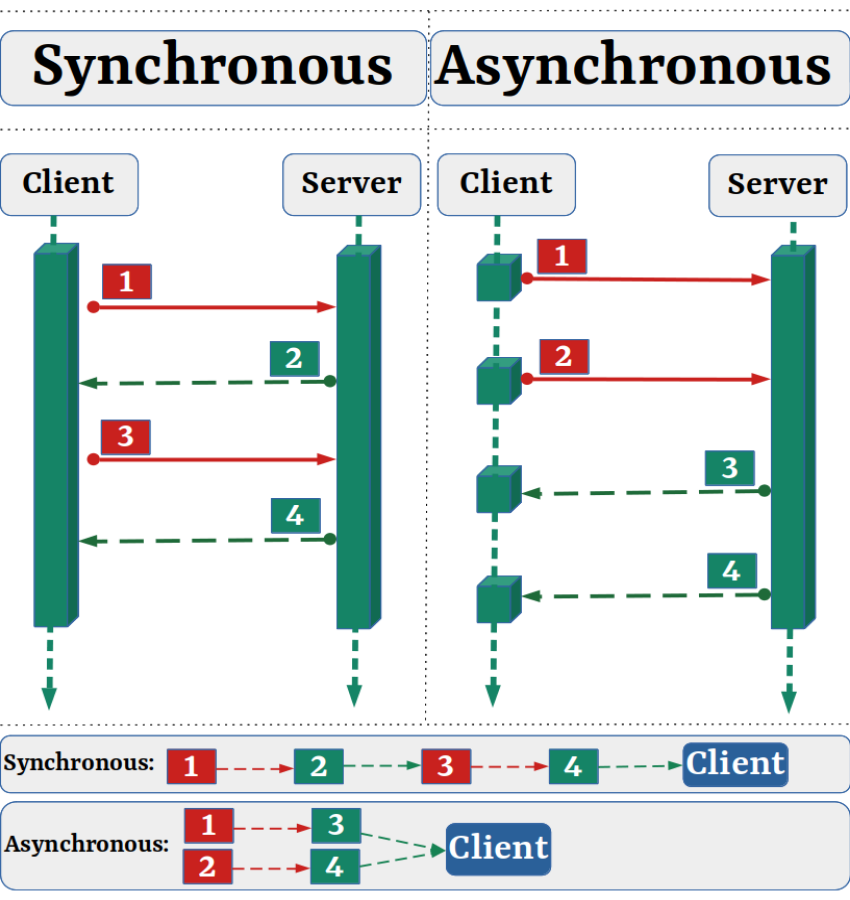



Tipo de Concurrencia: Concurrencia Cooperativa

Claves:

- 1 Unico stack, 1 Thread, 1 Proceso, one life
- Impacto bajisimo en memoria, es solo una corutina
- No genera race conditions, pues no hay Threads
- Hay un event loop que maneja que corutina o Task se ejecuta; cada Task **coopertivamente** libera la CPU.
- **Hay que cuidarse de los CPU hoarders**


In [ ]:
%%file asyncio-example.py
import asyncio
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(name)s:%(message)s')

log = logging.getLogger()

def main():
    loop = asyncio.get_event_loop()
    loop.run_until_complete(asyncio.gather(coroutine_1(), coroutine_2()))


async def coroutine_1():
    log.info('coroutine_1 is active on the event loop')

    log.info('coroutine_1 yielding control. Going to be blocked for 4 seconds')
    value = await asyncio.sleep(4)

    log.info('coroutine_1 resumed. coroutine_1 exiting with %s', value)


async def coroutine_2():
    log.info('coroutine_2 is active on the event loop')

    log.info('coroutine_2 yielding control. Going to be blocked for 5 seconds')
    await asyncio.sleep(5)

    log.info('coroutine_2 resumed. coroutine_2 exiting')


if __name__ == '__main__':
    main()

Overwriting asyncio-example.py


In [ ]:
!python asyncio-example.py

2023-11-24 00:28:49,780 INFO:root:coroutine_1 is active on the event loop
2023-11-24 00:28:49,781 INFO:root:coroutine_1 yielding control. Going to be blocked for 4 seconds
2023-11-24 00:28:49,781 INFO:root:coroutine_2 is active on the event loop
2023-11-24 00:28:49,781 INFO:root:coroutine_2 yielding control. Going to be blocked for 5 seconds
2023-11-24 00:28:53,784 INFO:root:coroutine_1 resumed. coroutine_1 exiting with None
2023-11-24 00:28:54,782 INFO:root:coroutine_2 resumed. coroutine_2 exiting


In [ ]:
%%file asyncio-bad-example.py
import asyncio
import time
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(name)s:%(message)s')

log = logging.getLogger()

def main():
    loop = asyncio.get_event_loop()
    loop.run_until_complete(asyncio.gather(good_coroutine(), bad_coroutine()))


async def bad_coroutine():
    log.info('Bad coroutine is active on the event loop')

    log.info('Bad  coroutine is NOT yielding control. Going to be blocked for 4 seconds')
    value = time.sleep(4)

    log.info('Bad coroutine resumed. Bad  coroutine exiting with %s', value)


async def good_coroutine():
    log.info('Good coroutine is active on the event loop')

    log.info('Good coroutine yielding control. Going to be blocked for 5 seconds')
    await asyncio.sleep(5)

    log.info('Good coroutine resumed. Good coroutine exiting')


if __name__ == '__main__':
    main()

Overwriting asyncio-bad-example.py


In [ ]:
!python  asyncio-bad-example.py

2023-11-24 00:28:55,001 INFO:root:Good coroutine is active on the event loop
2023-11-24 00:28:55,001 INFO:root:Good coroutine yielding control. Going to be blocked for 5 seconds
2023-11-24 00:28:55,001 INFO:root:Bad coroutine is active on the event loop
2023-11-24 00:28:55,001 INFO:root:Bad  coroutine is NOT yielding control. Going to be blocked for 4 seconds
2023-11-24 00:28:59,004 INFO:root:Bad coroutine resumed. Bad  coroutine exiting with None
2023-11-24 00:29:00,003 INFO:root:Good coroutine resumed. Good coroutine exiting


Intentemos replicar el ejemplo del counter

In [ ]:
import asyncio
import random
import time

counter = 0
worker_process_time = 0

async def worker(name, queue):
    global counter, worker_process_time
    while True:
        # Get a "work item" out of the queue.
        increment = await queue.get()
        time_start = time.monotonic()

        # Delegate toevent loop
        await asyncio.sleep(0)
        counter += increment

        time_end = time.monotonic()
        process_time = time_end - time_start
        worker_process_time += process_time

        # Notify the queue that the "work item" has been processed.
        queue.task_done()

In [ ]:
async def main():
    # Create a queue that we will use to store our "workload".
    queue = asyncio.Queue()

    # Generate random increments and put them into the queue.
    total = 0
    for _ in range(100):
        increment = random.randint(1, 10)
        total += increment
        queue.put_nowait(increment)
    # Create 5 worker tasks to process the queue concurrently.
    tasks = []
    workers = 5
    for i in range(workers):
        task = asyncio.create_task(worker(f'worker-{i}', queue))
        tasks.append(task)

    # Wait until the queue is fully processed.
    started_at = time.monotonic()
    await queue.join()
    total_time = time.monotonic() - started_at

    # Cancel our worker tasks.
    for task in tasks:
        task.cancel()

    # Wait until all worker tasks are cancelled.
    await asyncio.gather(*tasks, return_exceptions=True)

    print('====')
    print(f'{workers} workers worked in parallel and their counter is {counter}')
    print(f'Real result is {total}')
    print(f'Total worker process time is {worker_process_time:.5f}')
    print(f'Total time: {total_time:.5f} seconds')

In [ ]:

await main()

====
5 workers worked in parallel and their counter is 566
Real result is 566
Total worker process time is 0.00478
Total time: 0.00117 seconds


**Conclusiones**:

- En asyncio tenemos que ser buenos y dejar al event loop cada tanto
- Cada funcion es ahora una async functions que puede ser construida en una corutina de asyncio, que entrega un Future con los resultados cada vez que el selector le pregunta que onda
- Evitamos las race conditions y tenemos concurrencia de verdad
- Muy buen paradigma para laburar en I/O, es como Twisted, pero sin querer suicidarnos